<a href="https://colab.research.google.com/github/piotrwrzodak/UAM-DEEP-LEARNING/blob/master/2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.optim import SGD, Adam
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from typing import Literal
%matplotlib inline
device = "cuda" if torch.cuda.is_available() else "cpu"

In [2]:
train_data = MNIST(root='./data', train=True, transform=ToTensor(), download=True)
validation_data = MNIST(root='./data', train=False, transform=ToTensor(), download=True)

100%|██████████| 9912422/9912422 [05:00<00:00, 33014.92it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 132196.00it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:48<00:00, 33823.50it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 5322863.58it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [3]:
data_shape = train_data.data.shape

print(f'Shape:\t\t\t{data_shape}')
print(f'Number of images:\t{data_shape[0]}')
print(f'Number of channels:\t1 (greyscale)')
print(f'Image size:\t\t{data_shape[1]} x {data_shape[2]} (px)')
print(f'Unique classes:\t\t{train_data.classes}')
print(f'Unique values:\t\t{train_data.targets.unique()}')

Shape:			torch.Size([60000, 28, 28])
Number of images:	60000
Number of channels:	1 (greyscale)
Image size:		28 x 28 (px)
Unique classes:		['0 - zero', '1 - one', '2 - two', '3 - three', '4 - four', '5 - five', '6 - six', '7 - seven', '8 - eight', '9 - nine']
Unique values:		tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])


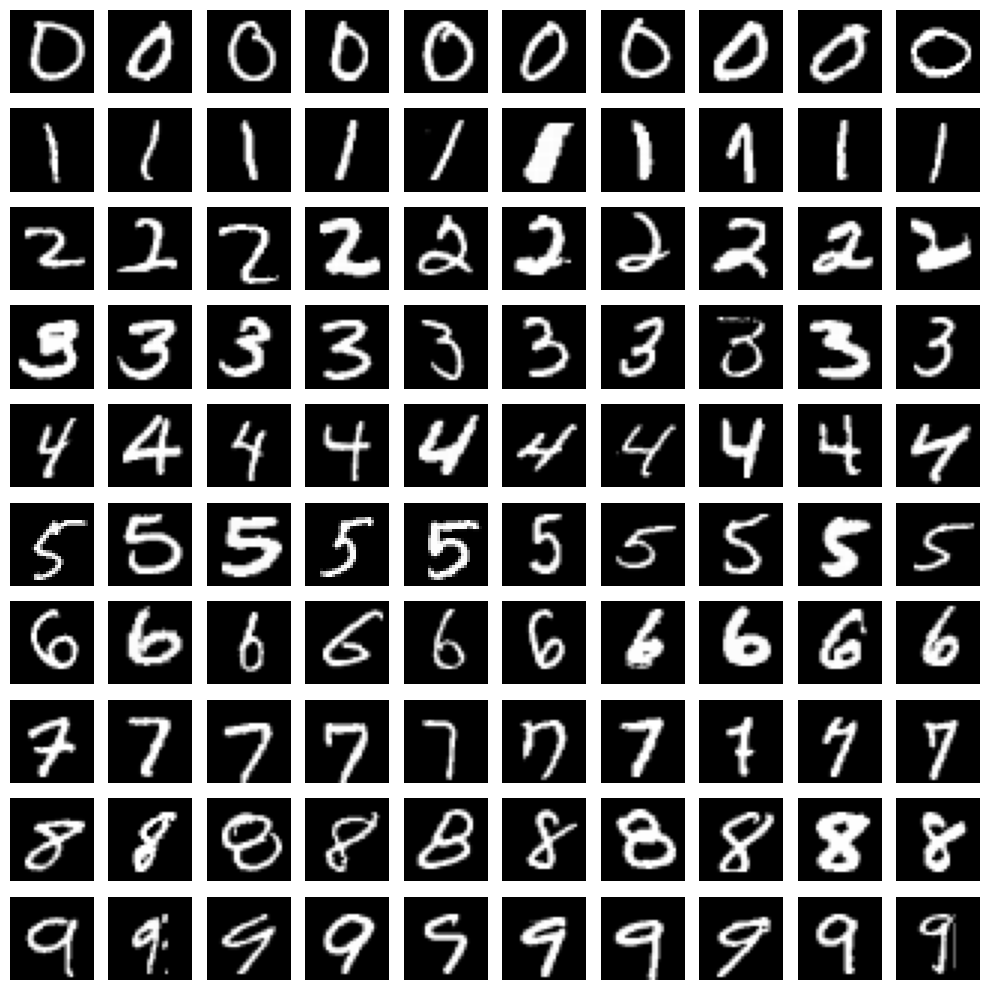

In [4]:
R, C = len(train_data.targets.unique()), 10
fig, ax = plt.subplots(R, C, figsize=(10,10))
for label_class, plot_row in enumerate(ax):
    label_x_rows = np.where(train_data.targets == label_class)[0]
    for plot_cell in plot_row:
        plot_cell.grid(False); plot_cell.axis('off')
        ix = np.random.choice(label_x_rows)
        x, y = train_data.data[ix], train_data.targets[ix]
        plot_cell.imshow(x, cmap='gray')
plt.tight_layout()

In [5]:
class MNISTDataset(Dataset):
  def __init__(self, x, y):
    x = x.float() / 255
    x = x.view(-1, 28 * 28)
    self.x, self.y = x, y
  def __getitem__(self, ix):
    x, y = self.x[ix], self.y[ix]
    return x.to(device), y.to(device)
  def __len__(self):
    return len(self.x)

In [6]:
def get_data():
  train = MNISTDataset(train_data.data, train_data.targets)
  trn_dl = DataLoader(train, batch_size=32, shuffle=True)
  val = MNISTDataset(validation_data.data, validation_data.targets)
  val_dl = DataLoader(val, batch_size=len(validation_data.data), shuffle=False)
  return trn_dl, val_dl

In [7]:
@torch.no_grad()
def val_loss(x, y, model):
  model.eval()
  prediction = model(x)
  val_loss = loss_fn(prediction, y)
  return val_loss.item()

In [8]:
def get_model(optimizer_name: Literal['Adam', 'SGD'], batch_size: int, learingin_rate: float):
    model = nn.Sequential(
        nn.Linear(28 * 28, 1000),
        nn.ReLU(),
        nn.Linear(1000, 10)
    ).to(device)
    loss_fn = nn.CrossEntropyLoss()
    if optimizer_name == 'Adam':
      optimizer = Adam(params=model.parameters(), lr=learingin_rate)
    else:
      optimizer = SGD(params=model.parameters(), lr=learingin_rate)
    return model, loss_fn, optimizer

In [9]:
def train_batch(x, y, model, opt, loss_fn):
    model.train() # <- let's hold on to this until we reach dropout section
    # call your model like any python function on your batch of inputs
    prediction = model(x)
    # compute loss
    batch_loss = loss_fn(prediction, y)
    # based on the forward pass in `model(x)` compute all the gradients of
    # 'model.parameters()'
    batch_loss.backward()
    # apply new-weights = f(old-weights, old-weight-gradients) where
    # "f" is the optimizer
    opt.step()
    # Flush gradients memory for next batch of calculations
    opt.zero_grad()
    return batch_loss.item()

In [10]:
@torch.no_grad()
def accuracy(x, y, model):
    model.eval()
    # this is the same as @torch.no_grad
    # at the top of function, only difference
    # being, grad is not computed in the with scope
    with torch.no_grad():
      prediction = model(x)
    max_values, argmaxes = prediction.max(-1)
    is_correct = argmaxes == y
    return is_correct.cpu().numpy().tolist()

In [11]:
def display_diagrams(tr_losses, val_losses, tr_acc, val_acc):
  epochs = np.arange(EPOCH_NUMBER)+1

  plt.subplot(211)
  plt.plot(epochs, tr_losses, 'bo', label='Training loss')
  plt.plot(epochs, val_losses, 'r', label='Validation loss')
  plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
  plt.title('Training and validation loss when batch size is 32')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  plt.grid('off')
  plt.show()
  plt.subplot(212)
  plt.plot(epochs, tr_acc, 'bo', label='Training accuracy')
  plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
  plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
  plt.title('Training and validation accuracy when batch size is 32')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()])
  plt.legend()
  plt.grid('off')
  plt.show()

In [12]:
def train_model(optimizer_name: Literal['Adam', 'SGD'], batch_size: int, learingin_rate: float):
  trn_dl, val_dl = get_data()
  train_losses, train_accuracies = [], []
  val_losses, val_accuracies = [], []

  for epoch in range(EPOCH_NUMBER):
      train_epoch_losses, train_epoch_accuracies = [], []
      for ix, batch in enumerate(iter(trn_dl)):
          x, y = batch
          batch_loss = train_batch(x, y, model, optimizer, loss_fn)
          train_epoch_losses.append(batch_loss)
      train_epoch_loss = np.array(train_epoch_losses).mean()

      for ix, batch in enumerate(iter(trn_dl)):
          x, y = batch
          is_correct = accuracy(x, y, model)
          train_epoch_accuracies.extend(is_correct)
      train_epoch_accuracy = np.mean(train_epoch_accuracies)

      for ix, batch in enumerate(iter(val_dl)):
          x, y = batch
          val_is_correct = accuracy(x, y, model)
          validation_loss = val_loss(x, y, model)
      val_epoch_accuracy = np.mean(val_is_correct)

      train_losses.append(train_epoch_loss)
      train_accuracies.append(train_epoch_accuracy)
      val_losses.append(validation_loss)
      val_accuracies.append(val_epoch_accuracy)
      print(f'Epoch: {epoch}; Train loss: {train_epoch_loss}; Val loss: {validation_loss}; Train accuracy: {train_epoch_accuracy}; Val accuracy: {val_epoch_accuracy}')

  display_diagrams(train_losses, val_losses, train_accuracies, val_accuracies)
  return model

In [13]:
EPOCH_NUMBER = 20

In [14]:

hyperparameters_variations = [
    ['SGD', 32, 0.0001]
]

Epoch: 0; Train loss: 2.277190320587158; Val loss: 2.2453622817993164; Train accuracy: 0.2884333333333333; Val accuracy: 0.2871
Epoch: 1; Train loss: 2.218028184636434; Val loss: 2.185626983642578; Train accuracy: 0.51265; Val accuracy: 0.5244
Epoch: 2; Train loss: 2.159792714309692; Val loss: 2.1258533000946045; Train accuracy: 0.62315; Val accuracy: 0.6334
Epoch: 3; Train loss: 2.1007522469202677; Val loss: 2.0646259784698486; Train accuracy: 0.6789; Val accuracy: 0.6905
Epoch: 4; Train loss: 2.0398347600301108; Val loss: 2.0011162757873535; Train accuracy: 0.71135; Val accuracy: 0.7237
Epoch: 5; Train loss: 1.9764495855967203; Val loss: 1.934969186782837; Train accuracy: 0.7303666666666667; Val accuracy: 0.7411
Epoch: 6; Train loss: 1.9104313725153605; Val loss: 1.8662011623382568; Train accuracy: 0.74285; Val accuracy: 0.7522
Epoch: 7; Train loss: 1.8419830842971803; Val loss: 1.7951748371124268; Train accuracy: 0.75135; Val accuracy: 0.7609
Epoch: 8; Train loss: 1.771605804379781;

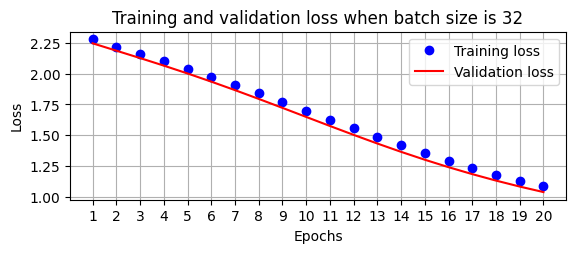

<ipython-input-11-c8f7d38fdec8>:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()])


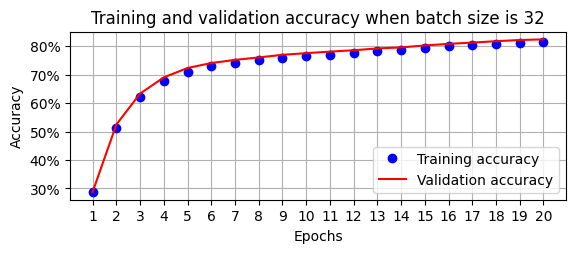

In [15]:
for optimizer, batch_size, lr in hyperparameters_variations:
  model, loss_fn, optimizer = get_model(optimizer, batch_size, lr)
  model = train_model(optimizer, batch_size, lr)

In [16]:
from IPython.display import Image
Image(url='https://media0.giphy.com/media/dVhX8dtOi4piZox0jC/giphy.gif?cid=6c09b952lc6r9sfyhd5zh1oj35gxn1r5ieqqkt53tro7pe7c&ep=v1_internal_gif_by_id&rid=giphy.gif&ct=s')